## 7.1 One Point Correlation Maps

A one point correlation map correlates a variable all over the globe with the same variable at a specific site.

Our aim is now, to correlate the northern hemisphere winter season geopotential @500 hPa to the winter season geopotential on Iceland. We expect a highly negative correlation between Iceland and the Azores! We will first need to load the data:

In [3]:
geop = xr.open_dataset('./data/ERA5-LowRes-MonthlyAvg-500hPa-UVZ.nc').sel(latitude=slice(90, 20)).z

We loaded the dataset, selected the northern hemisphere and the variable z all in on step. See what we got:

In [4]:
geop = xr.open_dataset('./data/ERA5-LowRes-MonthlyAvg-500hPa-UVZ.nc').sel(latitude=slice(90, 20)).z
geop

<xarray.DataArray 'z' (time: 480, latitude: 94, longitude: 480)>
[21657600 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 -179.625 -178.875 ... 178.875 179.625
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... 21.75 21.0 20.25
  * time       (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2018-12-01
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

Divide this by $9.8$ to get the geopotential height out of the geopotential!

In [5]:
geop = geop/9.8

That worked out well. Next, we need to get the two variables we need for the correlation: we need to select the winter season DJF plus take an average over each season and we need to create another variable, the geopotential of iceland (select lon and lat).

In [6]:
# create the northern hemisphere variable
geop_djf = geop.where(geop['time.season'] == 'DJF') #select winter season since correlation is strongest here
geop_djf = geop_djf.groupby('time.year').mean('time') #average over the year (over each season)

In [7]:
# create the iceland variable
iceland = geop_djf.sel(latitude=65, longitude=-30, method='nearest') #select the lat & lon coords of iceland
iceland

<xarray.DataArray 'z' (year: 40)>
array([5219.4985, 5253.3438, 5199.93  , 5176.067 , 5184.885 , 5087.6914,
       5300.2944, 5231.6616, 5329.336 , 5195.4614, 5109.012 , 5082.8613,
       5193.621 , 5143.64  , 5127.959 , 5152.036 , 5183.861 , 5291.31  ,
       5187.0254, 5196.9062, 5164.2188, 5221.406 , 5288.9146, 5204.1113,
       5224.7773, 5226.9243, 5290.7275, 5219.532 , 5209.4844, 5140.8438,
       5278.03  , 5382.8965, 5160.5396, 5234.792 , 5202.359 , 5163.7705,
       5118.613 , 5197.02  , 5237.7695, 5175.3315], dtype=float32)
Coordinates:
    longitude  float32 -29.625
    latitude   float32 65.25
  * year       (year) int64 1979 1980 1981 1982 1983 ... 2015 2016 2017 2018

What we aim to compute next is the correlation coefficient $r_{X,Y}$ of those two variables: 

$r_{X,Y} = \frac{cov(X,Y)}{\sigma_X\sigma_Y}$


$cov(X,Y) = \overline{(X-\overline{X})(Y-\overline{Y})}$

$r_{X,Y}$ can take values between $-1$ and $+1$, where $-1$ means perfect negative correlation and $+1$ perfect positive correlation of the two variables $X$ and $Y$.

To compute $r_{X,Y}$ of two specific sites is quite easy, since only the time dimension remains and the other coordinates (lat and lon) vanish. There is a special numpy method, that does exactly this: `np.corrcoef(X,Y)`.
Let's try this first:

In [8]:
azores = geop_djf.sel(latitude = 38, longitude = -25.5, method = 'nearest') #select lat,lon of azores
r_xy = np.corrcoef(iceland,azores)
r_xy

array([[ 1.        , -0.69632654],
       [-0.69632654,  1.        ]])

The numpy function returns a matrix of the following form:

$\left(\begin{array}{rr}                                
r_{X,X}  &  r_{X,Y}\\                                               
r_{Y,X}  &  r_{Y,Y} \\                                                                                            
\end{array}\right)$

so what we need is the upper right entry of this matrix. We can select it with `[0, 1]`:

In [9]:
r_xy [0,1] #select first row, second column

-0.6963265357989475

We can also plot a scatter plot of the geopotential of the azores vs. iceland with `plt.scatter(X,Y)`. We can clearly see the negative correlation in there too:

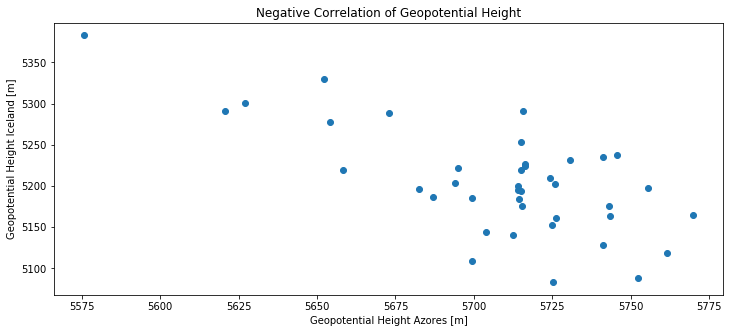

In [10]:
plt.scatter(azores, iceland)
plt.xlabel('Geopotential Height Azores [m]');
plt.ylabel('Geopotential Height Iceland [m]');
plt.title('Negative Correlation of Geopotential Height');

From this, we can already conclude that the icelandic low and the azores high are correlated. Still, a map would be more appealing to see which regions correlate and which do not. Therefore, we must compute the correlation coefficient for each grid point on the northern hemisphere. We can do this by two so called **for loops**!

What is a for loop?

A loop is a tool in programming, to repeat the same command for different variables with only one time writing the command itself. A for loop iterates over those variables. Let's try it on an example:


In [11]:
for i in list([1,2,3,4,5]): 
    print(i)

1
2
3
4
5


The for loop picks the i'th value out of the list, starting at $i=0$. Next, the command inside the for loop is executed: the ith list value (in this case 1) is printed. Next the for loop iteration selects $i=1$ and the execution of the print command prints 2, and so on until the end of the list is reached.
We can now also generate a nested set of two for loops:


In [12]:
for i in list([1,2,3,4,5]):
    for j in list([6,7,8,9,10]):
        print(i,j)
        

1 6
1 7
1 8
1 9
1 10
2 6
2 7
2 8
2 9
2 10
3 6
3 7
3 8
3 9
3 10
4 6
4 7
4 8
4 9
4 10
5 6
5 7
5 8
5 9
5 10


We start with $i=0$, so $1$ is printed. The $i$ value stays constant, while we loop through all the $j$ values! Once the j-loop is completed, $i$ is set to $1$ (the second value of the list is printed: $2$).

That's exactly what we need for our correlation coefficient map, that persists of the correlation coefficient at each grid point! We simply need to iterate over all latitudes and longitudes in a nested for loop and compute the correlation coeffiecient with `np.corrcoef(X,Y)` for each grid point. See the explanations underneath each line:

In [13]:
# first, we make an empty array that we will fill with the correlation coefficients of each grid point
cor_map = geop_djf[0,:,:] * 0.
# for loops over lats and lons
for j in np.arange(len(geop_djf.latitude)):
#len(geop_djf.latitude) returns the lengts of the latitude coordinate. np.arange(-"-) therefore creates an array 
#starting from 0 to len(geop_djf.latitude) --> those are the indexes we iterate with!
    for i in np.arange(len(geop_djf.longitude)):
        cor_map.values[j, i] = np.corrcoef(geop_djf.values[:, j, i], iceland.values)[0, 1]
        # for every lat, lon combination (j,i) we compute the np.corrcoef and safe it to the respective j,i matrix entry
        # of the predefined cor_map
        # geop_djf.values[:,j,i] selects all values in time, but only the latitude and longitude that we are dealing
        # with in this iteration (j,i)
        # iceland only has one lat and lon, so nothing needs to be selected
        # we use the .values attribute because this is much faster

Let's have a look if the just created `cor_map` looks as expected:


In [14]:
cor_map

<xarray.DataArray 'z' (latitude: 94, longitude: 480)>
array([[ 3.870026e-01,  3.870026e-01,  3.870026e-01, ...,  3.870026e-01,
         3.870026e-01,  3.870026e-01],
       [ 3.684703e-01,  3.684092e-01,  3.683630e-01, ...,  3.686890e-01,
         3.685948e-01,  3.685539e-01],
       [ 3.496436e-01,  3.494567e-01,  3.493008e-01, ...,  3.501951e-01,
         3.499781e-01,  3.497536e-01],
       ...,
       [ 3.440719e-03,  1.066956e-02,  1.757537e-02, ..., -1.836042e-02,
        -1.201352e-02, -4.382266e-03],
       [ 2.115448e-02,  2.841880e-02,  3.535205e-02, ...,  2.118021e-04,
         6.663880e-03,  1.365616e-02],
       [ 3.779970e-02,  4.474682e-02,  5.143892e-02, ...,  1.848689e-02,
         2.392346e-02,  3.056467e-02]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 -179.625 -178.875 ... 178.875 179.625
  * latitude   (latitude) float32 90.0 89.25 88.5 87.75 ... 21.75 21.0 20.25
    year       int64 1979

Now, we can plot the result of the correlation: the correlation coefficient! To get a nicer view on the northern hemisphere, we select a different projection, the North Polar Stereo Projection. 

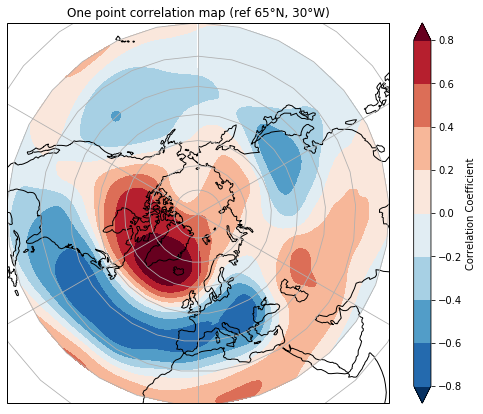

In [15]:
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.NorthPolarStereo()) 
ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
ax.coastlines(); ax.gridlines();
cs = cor_map.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'Correlation Coefficient'}, 
                           levels=np.linspace(-0.8, 0.8, 9), extend='both')
plt.title('One point correlation map (ref 65°N, 30°W)');

If you want, you can also make a circular plot instead of the quadratic one. First, you'll have to run these few lines (only once for the notebook!):

In [16]:
import matplotlib.path as mpath
theta = np.linspace(0, 2*np.pi, 100)
map_circle = mpath.Path(np.vstack([np.sin(theta), np.cos(theta)]).T * 0.5 + [0.5, 0.5])

And then add one line to the plot commands:

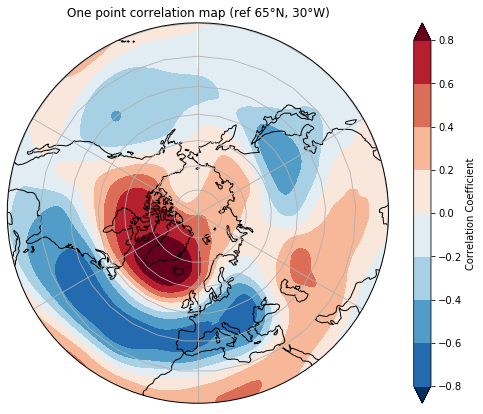

In [17]:
fig = plt.figure(figsize=(9, 7))
ax = plt.axes(projection=ccrs.NorthPolarStereo()) 
ax.set_boundary(map_circle, transform=ax.transAxes) #this is the only new line, the rest did not change
ax.set_extent([-180, 180, 20, 90], ccrs.PlateCarree())
ax.coastlines(); ax.gridlines();
cs = cor_map.plot.contourf(ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'label':'Correlation Coefficient'}, 
                           levels=np.linspace(-0.8, 0.8, 9), extend='both')
plt.title('One point correlation map (ref 65°N, 30°W)');